In [165]:
import pandas as pd
import os
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime



In [166]:
connection = sqlite3.connect('data/general.db')

tables = ['athletes', 'coaches', 'events', 'medallists', 'medals', 'medals_total',
    'nocs', 'schedules', 'schedules_preliminary', 'teams', 'technical_officials',
    'torch_route', 'venues']


#### Lets Load data from each table into a dictionary of DataFrames


In [167]:
data = {}
for table in tables:
    data[table] = pd.read_sql_query(f"SELECT * FROM {table}", connection)
connection.close()

#### Iterating over each tables to get the top 5 result from each table

In [168]:
for table, df in data.items():
    print(f"Table: {table}")
    print(df.head(),)

Table: athletes
      code current               name     name_short            name_tv  \
0  1532872    True   ALEKSANYAN Artur   ALEKSANYAN A   Artur ALEKSANYAN   
1  1532873    True     AMOYAN Malkhas       AMOYAN M     Malkhas AMOYAN   
2  1532874    True    GALSTYAN Slavik     GALSTYAN S    Slavik GALSTYAN   
3  1532944    True  HARUTYUNYAN Arsen  HARUTYUNYAN A  Arsen HARUTYUNYAN   
4  1532945    True    TEVANYAN Vazgen     TEVANYAN V    Vazgen TEVANYAN   

  gender function country_code  country country_long  ...  \
0   Male  Athlete          ARM  Armenia      Armenia  ...   
1   Male  Athlete          ARM  Armenia      Armenia  ...   
2   Male  Athlete          ARM  Armenia      Armenia  ...   
3   Male  Athlete          ARM  Armenia      Armenia  ...   
4   Male  Athlete          ARM  Armenia      Armenia  ...   

                                              family  \
0                          Father, Gevorg Aleksanyan   
1                                                     

#### Lets check for the null values

In [169]:
for table, df in data.items():
    print(f"cleaning table:{table}")

    print(df.isnull().sum())


#nothing found we are good

cleaning table:athletes
code                  0
current               0
name                  0
name_short            0
name_tv               0
gender                0
function              0
country_code          0
country               0
country_long          0
nationality           0
nationality_long      0
nationality_code      0
height                0
weight                0
disciplines           0
events                0
birth_date            0
birth_place           0
birth_country         0
residence_place       0
residence_country     0
nickname              0
hobbies               0
occupation            0
education             0
family                0
lang                  0
coach                 0
reason                0
hero                  0
influence             0
philosophy            0
sporting_relatives    0
ritual                0
other_sports          0
dtype: int64
cleaning table:coaches
code            0
current         0
name            0
gender          0
func

#### Converting all date columns to datetime type

In [170]:
if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])

#### Top 50 Countries with Athletes

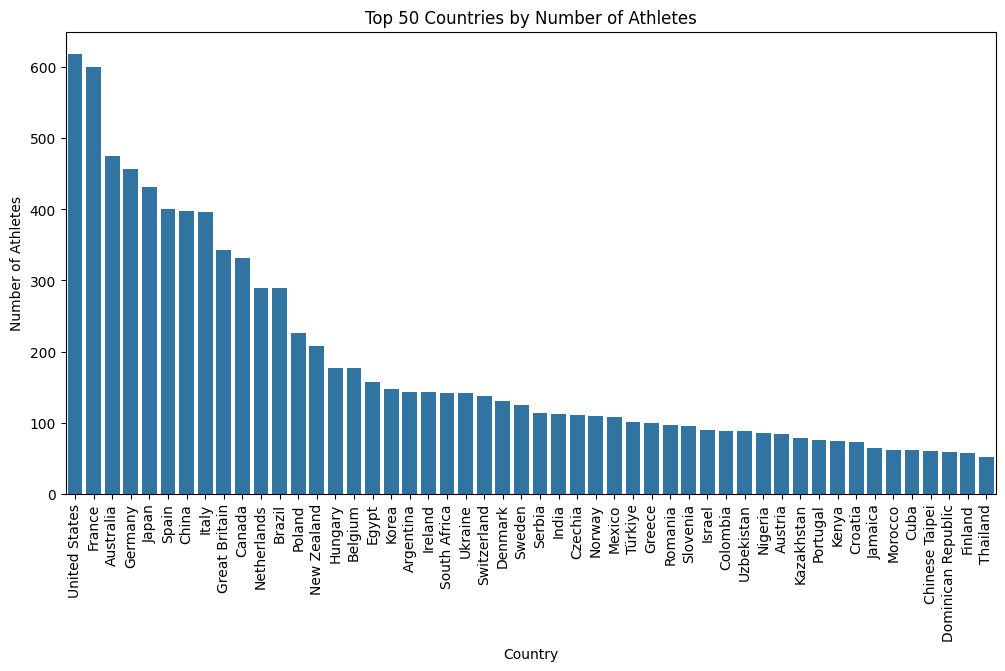

In [239]:
# Top 50 countries by number of athletes
top_50_countries = data['athletes']['country'].value_counts().nlargest(50)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_50_countries.index, y=top_50_countries.values)
plt.title('Top 50 Countries by Number of Athletes')
plt.xlabel('Country')
plt.ylabel('Number of Athletes')
plt.xticks(rotation=90)
plt.show()

In [172]:
# Calculated age from birth_date as there was birth_date cloumn instead of 'age'
current_year = datetime.now().year
data['athletes']['birth_date'] = pd.to_datetime(data['athletes']['birth_date'])
data['athletes']['age'] = current_year - data['athletes']['birth_date'].dt.year

In [173]:
# If birth_date is not recorded in table
data['athletes']['age'] = data['athletes']['age'].fillna(0).astype(int)

#### Atheletes by Age

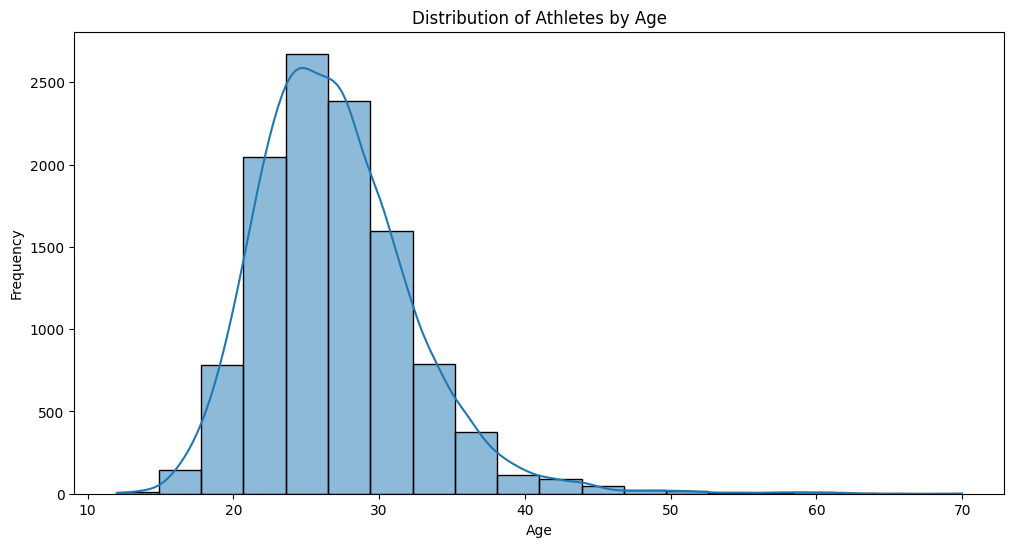

In [174]:
plt.figure(figsize=(12, 6))
sns.histplot(data['athletes']['age'], bins=20, kde=True)
plt.title('Distribution of Athletes by Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


In [175]:
# Counted unique athletes by 'name'
unique_athletes_count = data['athletes']['name'].nunique()
print(f"Number of unique athletes: {unique_athletes_count}")

Number of unique athletes: 11103


#### Male VS Female

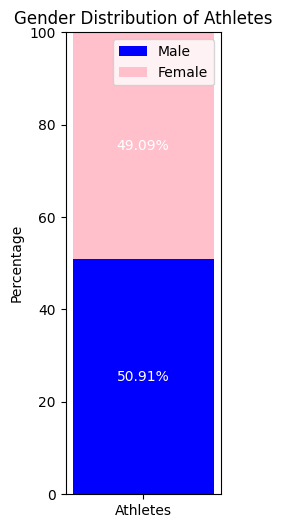

In [176]:
labels = ['Athletes']
male_percentage = gender_percentages.get('Male', 0)
female_percentage = gender_percentages.get('Female', 0)
values = [male_percentage, female_percentage]

fig, ax = plt.subplots(figsize=(2, 6))

# Ploted the stacked bar chart
ax.bar(labels, male_percentage, label='Male', color='blue')
ax.bar(labels, female_percentage, bottom=male_percentage, label='Female', color='pink')

# Added percentage labels
for i, v in enumerate(values):
    ax.text(0, sum(values[:i+1]) - v/2, f"{v:.2f}%", color='white', ha='center', va='center')

ax.set_title('Gender Distribution of Athletes')
ax.set_ylabel('Percentage')
ax.set_ylim(0, 100) 
ax.legend()

plt.show()

In [178]:
data['athletes']['height'] = pd.to_numeric(data['athletes']['height'], errors='coerce')

In [179]:
filtered_athletes = data['athletes'][data['athletes']['height'] >= 100]

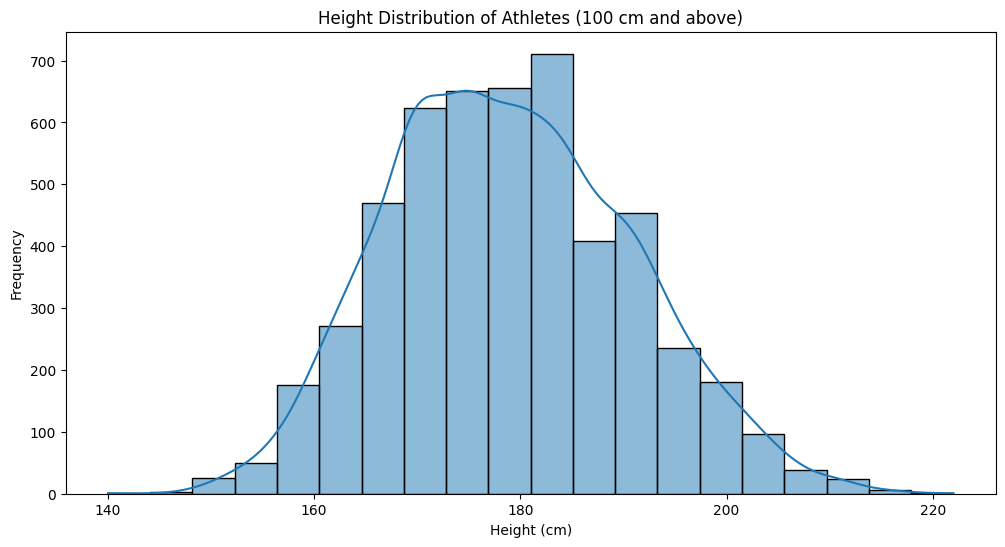

In [180]:
# Height distribution for heights 100 cm and above
plt.figure(figsize=(12, 6))
sns.histplot(filtered_athletes['height'].dropna(), bins=20, kde=True)
plt.title('Height Distribution of Athletes (100 cm and above)')
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')
plt.show()

In [181]:
# Droped records where either 'birth_country' or 'country' is missing
cleaned_athletes = data['athletes'].dropna(subset=['birth_country', 'country'])

In [182]:
# Counted the number of players born in each country
birth_country_counts = cleaned_athletes['birth_country'].value_counts()

In [183]:
# Counted the number of players representing each country
representing_country_counts = cleaned_athletes['country'].value_counts()

In [184]:
# Combined the counts into a single DataFrame
country_comparison = pd.DataFrame({
    'Born': birth_country_counts,
    'Representing': representing_country_counts
}).fillna(0)

In [185]:
# Calculated the total number of players for each country
country_comparison['Total'] = country_comparison['Born'] + country_comparison['Representing']

# Selected the top 50 countries based on the total number of players
top_50_countries = country_comparison.nlargest(50, 'Total')

#### Number of Players Born in Country vs. Representing thier playing Country

<Figure size 2000x1000 with 0 Axes>

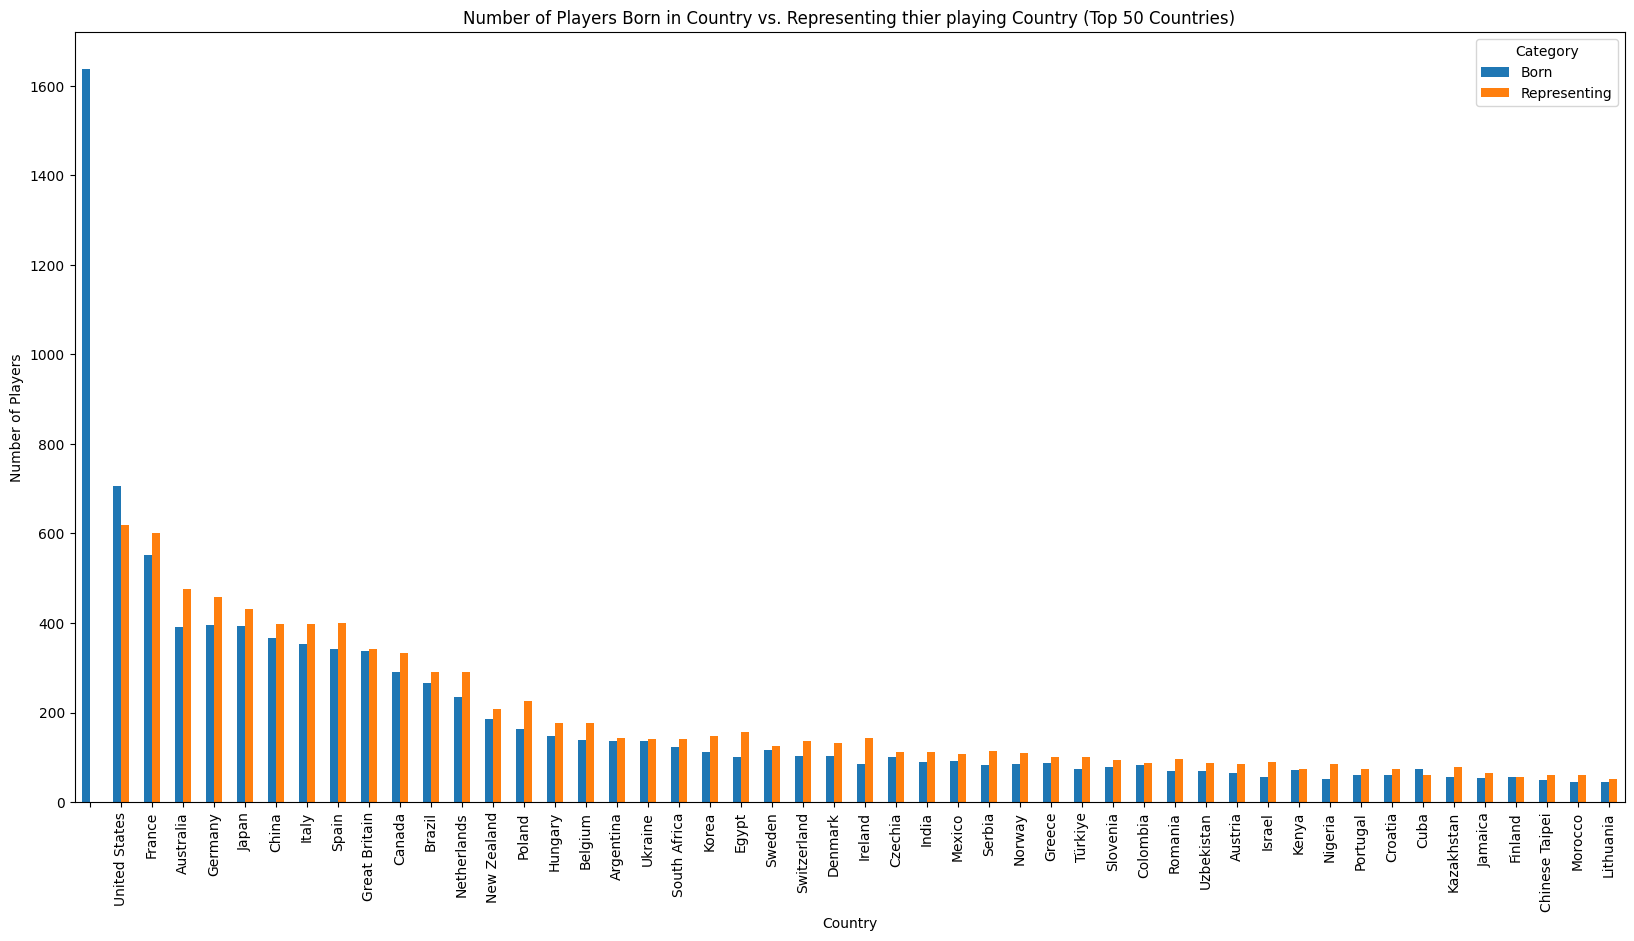

In [186]:
# Ploted the grouped bar chart
plt.figure(figsize=(20, 10))
top_50_countries[['Born', 'Representing']].plot(kind='bar', stacked=False, figsize=(20, 10))
plt.title('Number of Players Born in Country vs. Representing thier playing Country (Top 50 Countries)')
plt.xlabel('Country')
plt.ylabel('Number of Players')
plt.xticks(rotation=90)
plt.legend(title='Category')
plt.show()

#### Male vs Female by country

<Figure size 5000x2000 with 0 Axes>

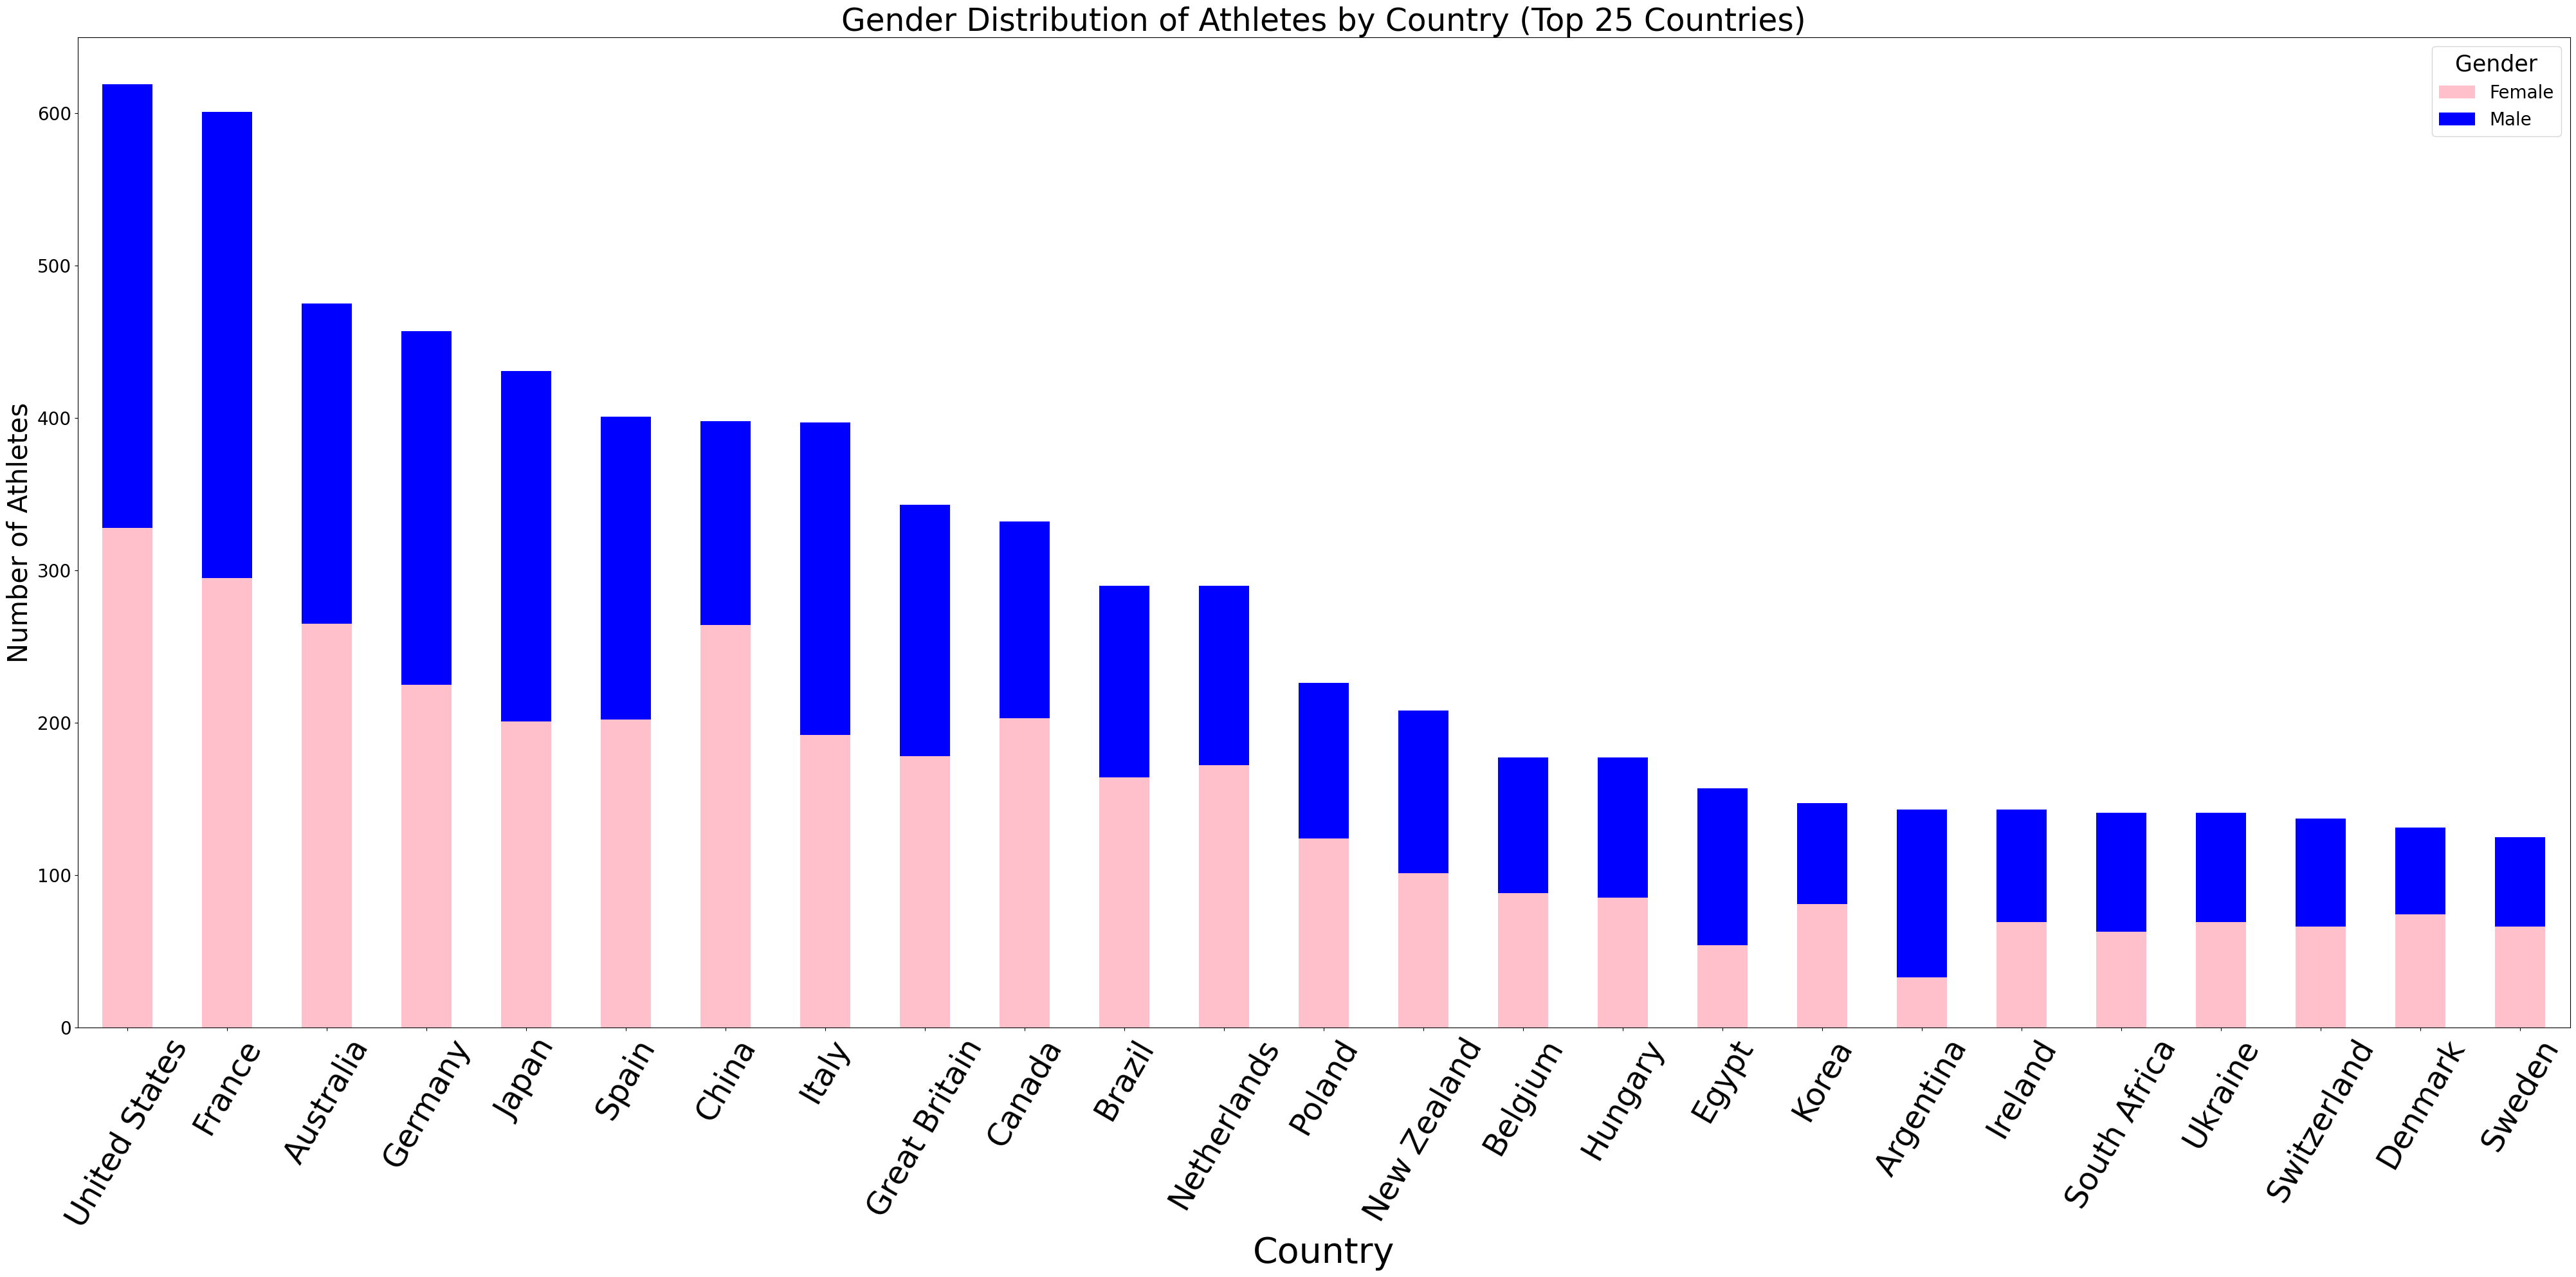

In [238]:
# Counted the number of male and female athletes representing each country
gender_country_counts = cleaned_athletes.groupby(['country', 'gender']).size().unstack(fill_value=0)

# Selected the top 25 countries based on the total number of athletes
top_25_countries_gender = gender_country_counts.sum(axis=1).nlargest(25).index
top_25_gender_country_counts = gender_country_counts.loc[top_25_countries_gender]

# Ploted the grouped bar chart
plt.figure(figsize=(50, 20))
top_25_gender_country_counts.plot(kind='bar', stacked=True, figsize=(50, 20), color=['pink', 'blue'])
plt.title('Gender Distribution of Athletes by Country (Top 25 Countries)', fontsize=35)
plt.xlabel('Country', fontsize=40)
plt.ylabel('Number of Athletes', fontsize=30)
plt.xticks(rotation=60, fontsize=35)
plt.yticks(fontsize=20)
plt.legend(title='Gender', fontsize=20, title_fontsize=25)
plt.show()

In [188]:
# removed the brackets error
cleaned_athletes['disciplines'] = cleaned_athletes['disciplines'].apply(lambda x: x.strip("[]").replace("'", ""))

#### Disciplines with most number of Athletes

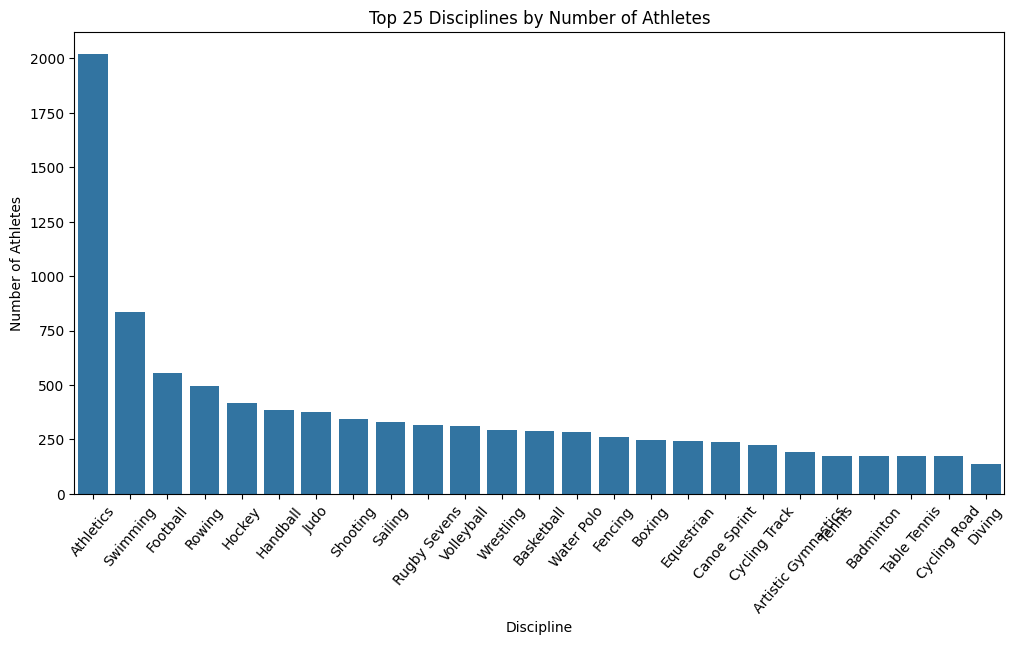

In [189]:
# Counted the number of athletes in each discipline
discipline_counts = cleaned_athletes['disciplines'].value_counts()

# Selected the top 10 disciplines
top_25_disciplines = discipline_counts.nlargest(25)

# Ploted the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_25_disciplines.index, y=top_25_disciplines.values)
plt.title('Top 25 Disciplines by Number of Athletes')
plt.xlabel('Discipline')
plt.ylabel('Number of Athletes')
plt.xticks(rotation=50, fontsize=10)
plt.show()

In [190]:
# Joined athletes and medallists tables on 'country_code'
athletes_medallists = pd.merge(data['athletes'], data['medallists'], on='country_code', how='inner')

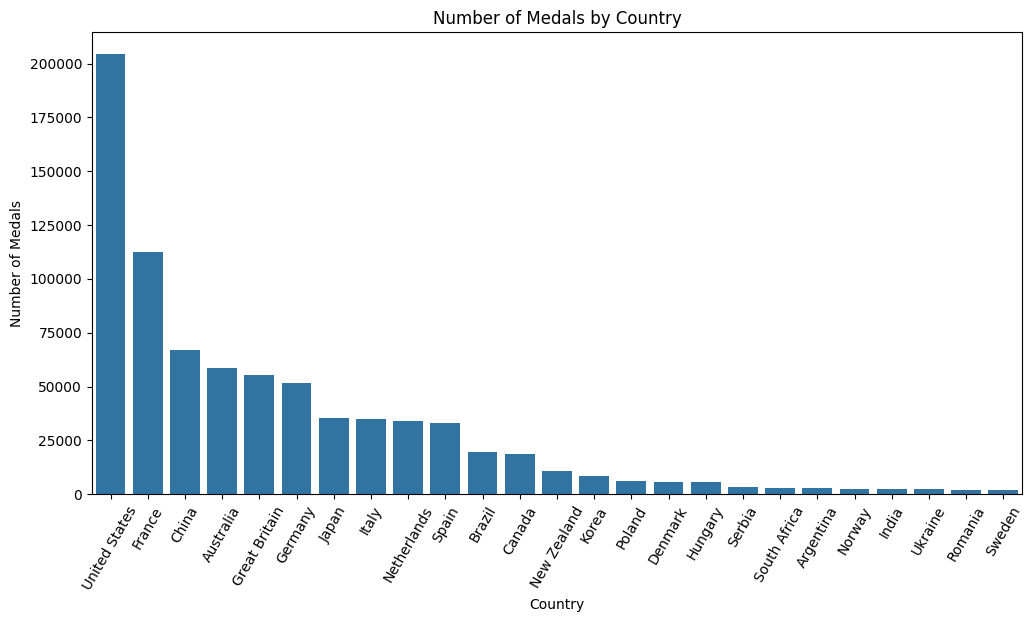

In [191]:
# Counted the number of medals by country
medals_by_country = athletes_medallists['country_x'].value_counts()

top_25_mdl_countries = medals_by_country.nlargest(25)
# Ploted the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_25_mdl_countries.index, y=top_25_mdl_countries.values)
plt.title('Number of Medals by Country')
plt.xlabel('Country')
plt.ylabel('Number of Medals')
plt.xticks(rotation=60)
plt.show()

In [218]:
connection = sqlite3.connect('data/general.db')

try:
    # Load data from the 'athletes' and 'medallists' tables into DataFrames
    athletes_df = pd.read_sql_query("SELECT * FROM athletes", connection)
    medallists_df = pd.read_sql_query("SELECT * FROM medallists", connection)
    medals_df = pd.read_sql_query("SELECT * FROM medals", connection)

finally:
    # Close the connection
    connection.close()

In [195]:
# Joined athletes and medallists tables on 'code' and 'code_athlete'
athletes_medallists = pd.merge(athletes_df, medallists_df, left_on='code', right_on='code_athlete', how='inner')

In [202]:
# Counted the number of medals for each athlete
medals_by_athlete = athletes_medallists.groupby('name_x').size().reset_index(name='medal_count')

# Sorted the athletes by the number of medals in descending order
top_athletes = medals_by_athlete.sort_values(by='medal_count', ascending=False).head(20)

/var/folders/k8/lq3sh67104n34dn13hr52z8w0000gn/T/ipykernel_39047/126133173.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='medal_count', y='name_x', data=top_athletes, palette='viridis')


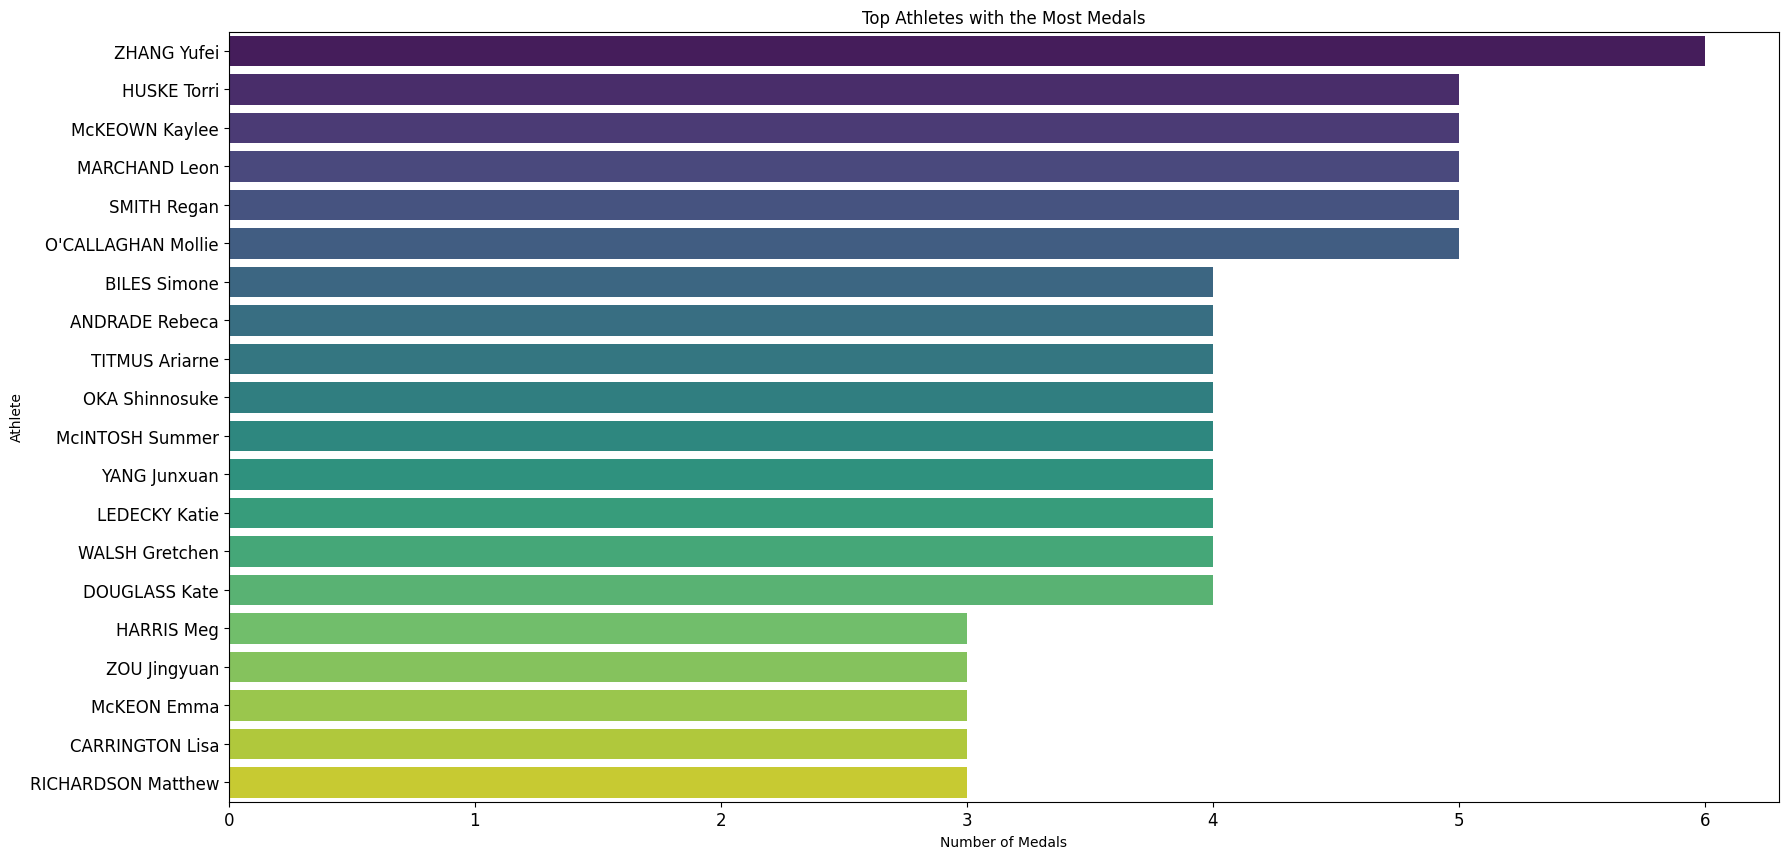

In [209]:
# Ploted the bar chart
plt.figure(figsize=(20, 10))
sns.barplot(x='medal_count', y='name_x', data=top_athletes, palette='viridis')
plt.title('Top Athletes with the Most Medals')
plt.xlabel('Number of Medals')
plt.ylabel('Athlete')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [214]:
connection = sqlite3.connect('data/general.db')

try:
    # Loaded data from the 'schedules' table into a DataFrame
    schedules_df = pd.read_sql_query("SELECT * FROM schedules", connection)
finally:
    # Closed the connection
    connection.close()

In [216]:
# Counted the number of events by location_description and location_code
events_by_location = schedules_df.groupby(['location_description', 'location_code']).size().reset_index(name='event_count')

# Sorted the locations by the number of events in descending order
top_locations = events_by_location.sort_values(by='event_count', ascending=False).head(10)

/var/folders/k8/lq3sh67104n34dn13hr52z8w0000gn/T/ipykernel_39047/3486753203.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='event_count', y='location_description', data=top_locations, palette='viridis')


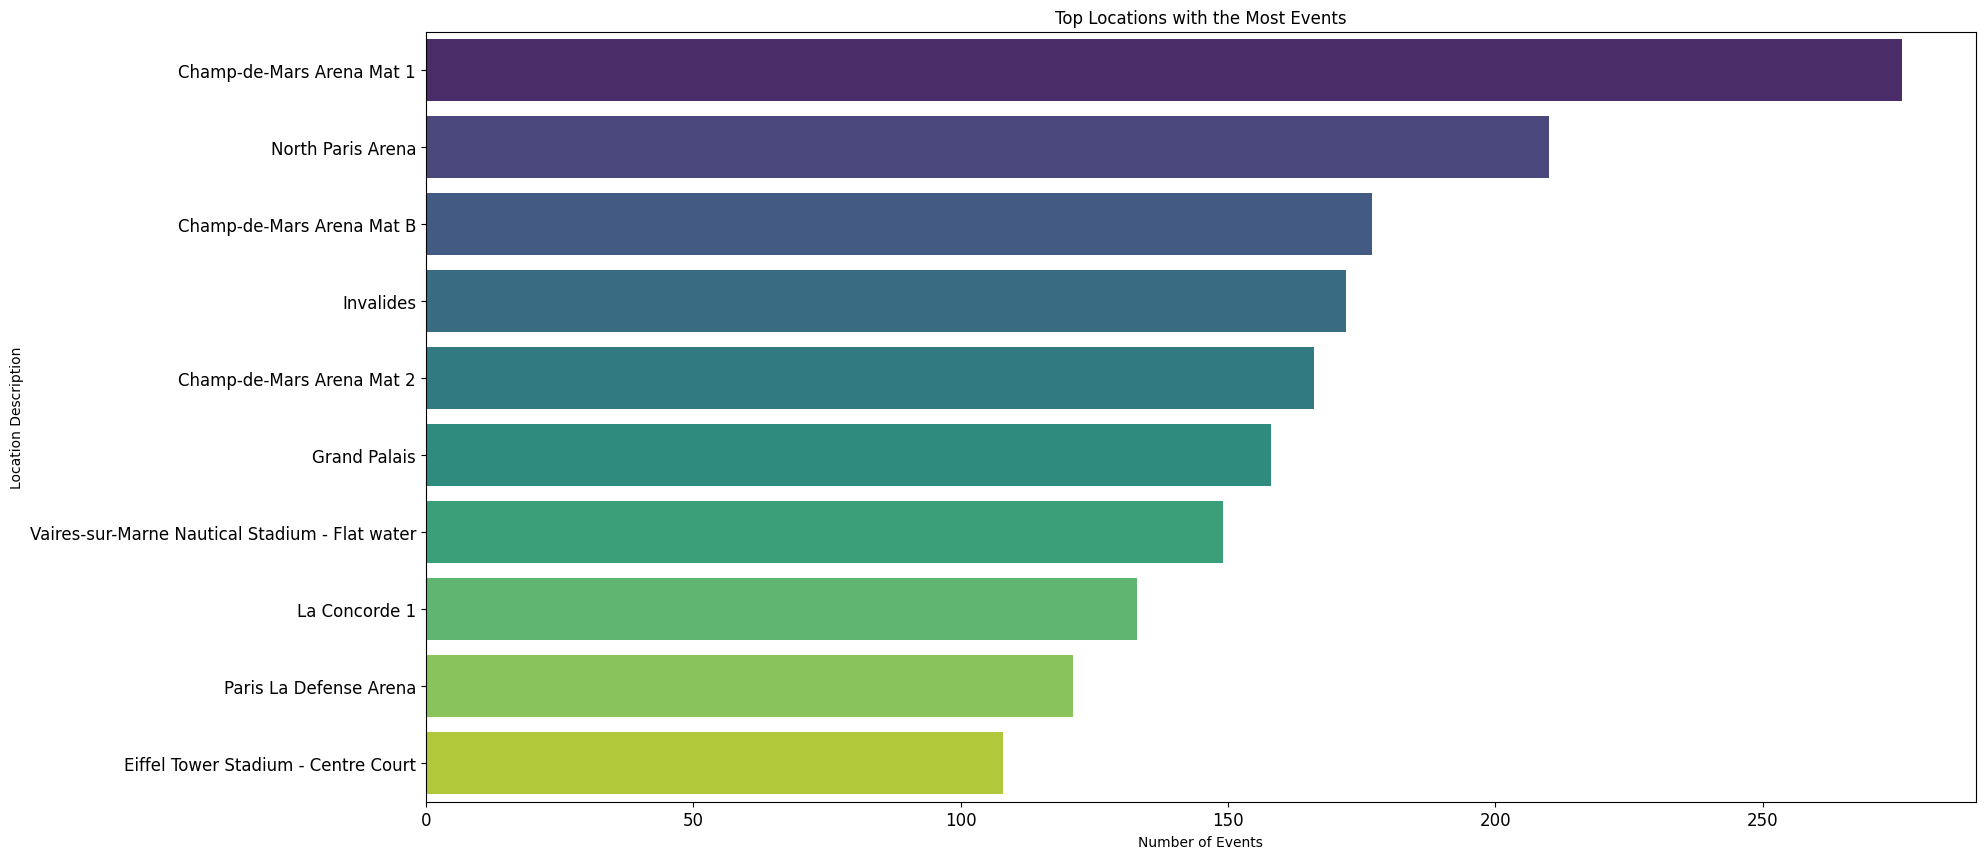

In [217]:
plt.figure(figsize=(20, 10))
sns.barplot(x='event_count', y='location_description', data=top_locations, palette='viridis')
plt.title('Top Locations with the Most Events')
plt.xlabel('Number of Events')
plt.ylabel('Location Description')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# there can be multiple events at same time in a particular place, or 
# event may occur simultaneously at different venues at same time

In [220]:
# Counted the number of each type of medal for each country
medals_by_country = medals_df.groupby(['country_code', 'medal_type']).size().reset_index(name='medal_count')

# Pivot the table to have medal types as columns
medals_pivot = medals_by_country.pivot(index='country_code', columns='medal_type', values='medal_count').fillna(0)

# Reset the index to make 'country_code' a column again
medals_pivot.reset_index(inplace=True)

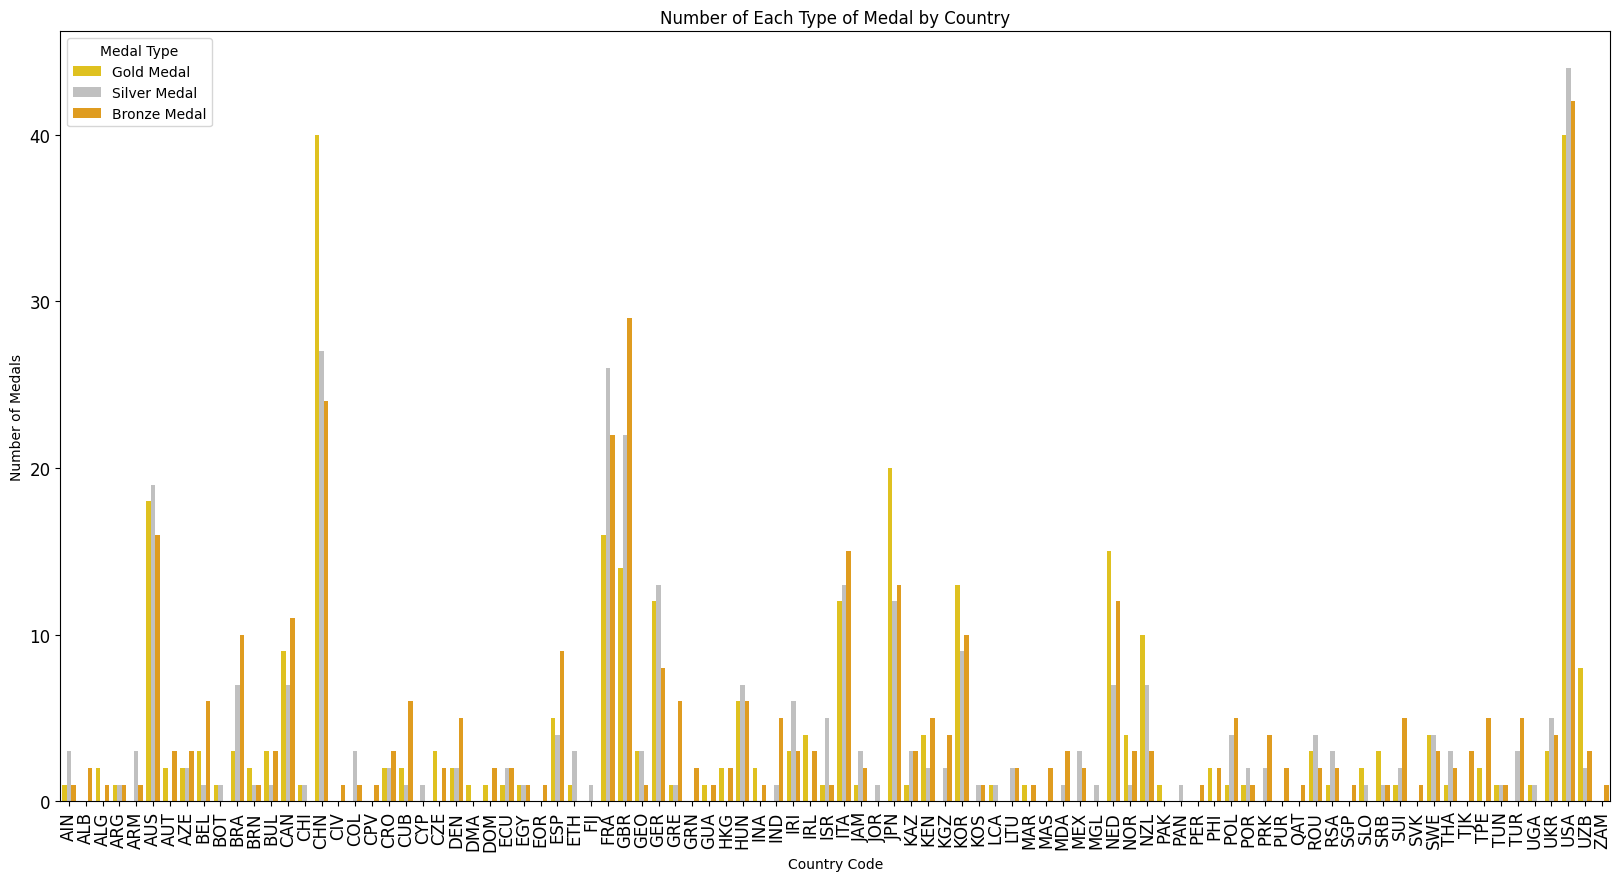

In [224]:
# Melted the pivot table to long format for easier plotting with seaborn
medals_melted = medals_pivot.melt(id_vars='country_code', value_vars=['Gold Medal', 'Silver Medal', 'Bronze Medal'], var_name='medal_type', value_name='medal_count')


# Defined the custom color palette
custom_palette = {
    'Gold Medal': 'gold',
    'Silver Medal': 'silver',
    'Bronze Medal': 'orange'
}

# Ploted the bar chart
plt.figure(figsize=(20, 10))
sns.barplot(x='country_code', y='medal_count', hue='medal_type', data=medals_melted, palette=custom_palette)
plt.title('Number of Each Type of Medal by Country')
plt.xlabel('Country Code')
plt.ylabel('Number of Medals')
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Medal Type')
plt.show()

In [237]:
from tabulate import tabulate

# Converted the pivot table to a tabular format
medals_table = medals_pivot.reset_index()


In [236]:
medals_df['medal_type'] = medals_df['medal_type'].astype(str)
medals_df['country_code'] = medals_df['country_code'].astype(str)

# Created a pivot table to summarize the number of each type of medal by country
medals_pivot = medals_df.pivot_table(index='country_code', columns='medal_type', aggfunc='size', fill_value=0)

# Added a column for the total number of medals
medals_pivot['Total Medals'] = medals_pivot.sum(axis=1)

# Sorted the table by the total number of medals in descending order
medals_pivot_sorted = medals_pivot.sort_values(by='Total Medals', ascending=False)

# Displayed the table using tabulate for console output
medals_table = medals_pivot_sorted.reset_index()
print(tabulate(medals_table, headers='keys', tablefmt='psql'))



+----+----------------+----------------+--------------+----------------+----------------+
|    | country_code   |   Bronze Medal |   Gold Medal |   Silver Medal |   Total Medals |
|----+----------------+----------------+--------------+----------------+----------------|
|  0 | USA            |             42 |           40 |             44 |            126 |
|  1 | CHN            |             24 |           40 |             27 |             91 |
|  2 | GBR            |             29 |           14 |             22 |             65 |
|  3 | FRA            |             22 |           16 |             26 |             64 |
|  4 | AUS            |             16 |           18 |             19 |             53 |
|  5 | JPN            |             13 |           20 |             12 |             45 |
|  6 | ITA            |             15 |           12 |             13 |             40 |
|  7 | NED            |             12 |           15 |              7 |             34 |
|  8 | GER